In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class BasicBlock(nn.Module):
  
    expansion = 1  
    def __init__(self, in_planes, planes, stride = 1):
        
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, padding=1, bias=False, stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        
    
    def forward(self, x):
        
        identity = x
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += self.shortcut(identity)
        x = F.relu(x)
        
        return x


In [6]:
class BottleNeck(nn.Module):

    expansion = 4
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2D(planes, planes, 3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        
    def forward(self, x):
        
        identity = x
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x += self.shortcut(identity)
        x = F.relu(x)
        
        return x
        
        

In [0]:
class ResNet(nn.Module):
    
    def __init__(self, block, num_blocks ,num_classes=10):
        
        super().__init__()
        
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)     
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self.makeResnetLayer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.makeResnetLayer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.makeResnetLayer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.makeResnetLayer(block, 512, num_blocks[3], stride=2)
        
        
        self.globalavgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512*block.expansion,num_classes)
    
    def makeResnetLayer(self, block, planes, n, stride):
             
        layer = []
        
        layer.append(block(self.in_planes, planes, stride))
        self.in_planes = block.expansion*planes
        for i in range(n-1):
            layer.append(block(self.in_planes, planes))
            self.in_planes = block.expansion*planes
        
        subBlock = nn.Sequential(*layer)
        return subBlock
    
    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.globalavgpool(x)
        x = x.view(-1, self.find_shape(x))
        x = self.fc(x)
        x = F.softmax(x, dim =1)
        
        return x
    
    def find_shape(self, x):
        res = 1
        for dim in x[0].shape:
            res *= dim
        return res
   

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(BottleNeck, [3,4,6,3])

def ResNet101():
    return ResNet(BottleNeck, [3,4,23,3])

def ResNet152():
    return ResNet(BottleNeck, [3,8,36,3])

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [0]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

trainset = torchvision.datasets.CIFAR10(root = './data', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root = './data', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(device)

cuda:0


In [0]:
len(testloader)

79

In [0]:
model = ResNet(BasicBlock, [16,32,64], 5)


In [0]:
model = model.to(device)
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60,70,80], gamma=0.1)

In [0]:
model.train()

lossList = []
accuracyList = []

for epoch in range(100):
    
    running_loss = 0.0
    correct, total = 0, 0
    correct_epoch, total_epoch = 0, 0
    
    scheduler.step()
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        c = (torch.argmax(outputs,1) == labels)
        correct += torch.sum(c)
        total += 128
        correct_epoch += torch.sum(c)
        total_epoch += 128
        
        if i % 60 == 59:    # print every 60 mini-batches
            print('[%d, %5d] loss: %.7f accuracy: [%d, %d] (%d %%)' % (epoch + 1, i + 1, running_loss / 200, correct, total, 100*correct/total))
            lossList.append(running_loss)
            running_loss = 0.0
            correct = 0
            total = 0
    
    print('<=========== accuracy after {} epoch is [{:d} {:d}] ({:d} %) ===========>)'.format(epoch+1, correct_epoch, total_epoch, 100*correct_epoch/total_epoch))
    accuracyList.append(100*correct_epoch/total_epoch)

print('Finished Training')


[1,    60] loss: 0.4535989 accuracy: [7289, 7680] (94 %)
[1,   120] loss: 0.4529801 accuracy: [7302, 7680] (95 %)
[1,   180] loss: 0.4534094 accuracy: [7294, 7680] (94 %)
[1,   240] loss: 0.4523525 accuracy: [7320, 7680] (95 %)
[1,   300] loss: 0.4528204 accuracy: [7309, 7680] (95 %)
[1,   360] loss: 0.4529824 accuracy: [7304, 7680] (95 %)
<=========== accuracy after 1 epoch is [47548 50048] (95 %) ===========>)
[2,    60] loss: 0.4532910 accuracy: [7298, 7680] (95 %)
[2,   120] loss: 0.4532332 accuracy: [7298, 7680] (95 %)
[2,   180] loss: 0.4520499 accuracy: [7328, 7680] (95 %)
[2,   240] loss: 0.4526871 accuracy: [7312, 7680] (95 %)
[2,   300] loss: 0.4531597 accuracy: [7299, 7680] (95 %)
[2,   360] loss: 0.4533353 accuracy: [7296, 7680] (95 %)
<=========== accuracy after 2 epoch is [47554 50048] (95 %) ===========>)
[3,    60] loss: 0.4529740 accuracy: [7304, 7680] (95 %)
[3,   120] loss: 0.4531358 accuracy: [7300, 7680] (95 %)
[3,   180] loss: 0.4544263 accuracy: [7268, 7680] (94 

KeyboardInterrupt: ignored

In [0]:
torch.save(model.state_dict(), '/home/resnet1')

In [0]:
model.eval()
class_correct = list( 0.0 for i in range(10))
class_total = list(0.0 for i in range(10))
correct = 0.0
total = 0.0


with torch.no_grad():
  for data in testloader:
    input, labels = data
#     inputs = changetocuda(input)
    output_raw = (model(input.cuda())).to('cpu')
    output = torch.argmax(output_raw,1)
    c = (output == labels)
    
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
      correct += c[i].item()
      total +=1
      

for i in range(10):
    print('Accuracy of %1d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))
    
print ('accuracy of test set is %2.2f %%' % (correct/total*100))

Accuracy of 0 : 79 %
Accuracy of 1 : 93 %
Accuracy of 2 : 75 %
Accuracy of 3 : 77 %
Accuracy of 4 : 78 %
Accuracy of 5 : 74 %
Accuracy of 6 : 84 %
Accuracy of 7 : 89 %
Accuracy of 8 : 100 %
Accuracy of 9 : 94 %
accuracy of test set is 84.49 %


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
dataiter = iter(testloader)

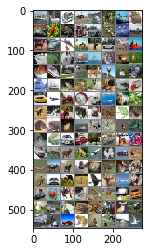

tensor([8, 4, 1, 2, 8, 4, 8, 6, 9, 2, 6, 9, 9, 0, 0, 0, 7, 1, 0, 7, 4, 1, 7, 8,
        3, 4, 5, 8, 8, 3, 4, 2, 3, 8, 9, 2, 4, 2, 5, 1, 9, 8, 6, 4, 3, 3, 8, 9,
        1, 0, 9, 5, 9, 0, 5, 0, 7, 7, 5, 6, 9, 4, 6, 4, 3, 8, 6, 8, 2, 2, 2, 2,
        3, 6, 1, 1, 7, 1, 7, 9, 1, 3, 4, 6, 0, 5, 8, 6, 0, 9, 5, 9, 3, 4, 3, 7,
        6, 1, 7, 4, 6, 4, 0, 5, 1, 0, 5, 3, 0, 7, 9, 1, 5, 9, 7, 6, 2, 9, 5, 4,
        9, 1, 1, 6, 2, 7, 8, 2])
tensor([8, 4, 1, 2, 8, 6, 8, 6, 8, 2, 6, 9, 9, 0, 0, 0, 7, 1, 0, 7, 4, 1, 7, 8,
        2, 4, 5, 8, 8, 3, 4, 2, 3, 8, 7, 2, 4, 2, 5, 1, 9, 8, 6, 4, 3, 3, 8, 9,
        1, 0, 9, 5, 9, 0, 3, 3, 7, 7, 5, 6, 4, 4, 6, 4, 3, 8, 6, 8, 6, 2, 2, 6,
        3, 9, 1, 1, 7, 1, 7, 9, 1, 3, 4, 6, 0, 5, 8, 6, 0, 9, 5, 9, 3, 4, 3, 7,
        6, 1, 7, 4, 6, 4, 0, 5, 1, 0, 5, 3, 2, 7, 0, 1, 5, 9, 7, 3, 2, 9, 3, 4,
        9, 1, 1, 6, 2, 7, 8, 8])
tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1

In [0]:
input, labels = dataiter.next()
imshow(torchvision.utils.make_grid(input))
print(labels)
print
output = model(input.cuda()).to('cpu')
# print(output)

out = torch.argmax(output, 1)
print(out)

print(out == labels)